<a href="https://colab.research.google.com/github/ArpitRawat07/DeepLearning_ImageClassification/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-584d1cc4-a8a8-9829-49de-05a6dade16f2)


In [1]:
# importing dependencies
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.preprocessing as preprocessing
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *

In [2]:
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [3]:
# List all the datasets available in tfds
datasets_list = tfds.list_builders()
datasets_list[:20]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z']

In [4]:
# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [5]:
# Load in the food101 data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3CMU5Q/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3CMU5Q/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
class_names = ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [8]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [9]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image data type: {image.dtype}
  Target class from food101 (Tensor Form): {label}
  Class name (String Form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 289, 3)
  Image data type: <dtype: 'uint8'>
  Target class from food101 (Tensor Form): 45
  Class name (String Form): frozen_yogurt
  


In [11]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [13]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

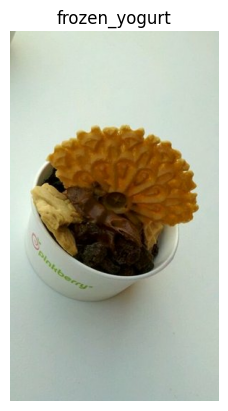

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
preprocess_img(image, label,224)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[147.19739, 153.19739, 127.19739],
         [157.22768, 163.22768, 137.22768],
         [158.09805, 164.09805, 138.09805],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 199.     ],
         [198.09914, 208.38936, 199.24425]],
 
        [[154.69467, 160.69467, 134.69467],
         [155.87053, 161.87053, 135.87053],
         [158.39908, 164.39908, 138.39908],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 199.     ],
         [196.32831, 206.61853, 195.76364]],
 
        [[154.56473, 158.56473, 133.56473],
         [153.49234, 158.17635, 132.83435],
         [157.76036, 163.3318 , 137.54608],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 197.87054],
         [197.85489, 208.51149, 197.1832 ]],
 
        ...,
 
        [[176.88599, 189.88599, 180.88599],
         [175.68573, 188.96552, 179.87225]

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240114-114132
Epoch 1/3
2368/2368 [==============================] - 183s 72ms/step - loss: 1.7198 - accuracy: 0.5808 - val_loss: 1.1308 - val_accuracy: 0.7002
Epoch 2/3
2368/2368 [==============================] - 187s 78ms/step - loss: 1.1990 - accuracy: 0.6896 - val_loss: 1.0260 - val_accuracy: 0.7169
Epoch 3/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.0530 - accuracy: 0.7234 - val_loss: 0.9937 - val_accuracy: 0.7251


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 0.9997 - accuracy: 0.7275


[0.9997352361679077, 0.7275247573852539]

## Creating a new feature extraction model with more callbacks and then fine tuning it.

In [19]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "food101_efficientnetb7_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [20]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [21]:
# Input shape
input_shape = (224, 224, 3)

# Using EfficientNetB7 this time
base_model_2 = keras.applications.efficientnet.EfficientNetB7(include_top=False)
base_model_2.trainable = False

inputs = layers.Input(input_shape, name = "Input_Layer")

x = base_model_2(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

258076736/258076736 [==============================] - 1s 0us/step


In [22]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 2560)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               258661    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                          

In [23]:
# Fitting the model
history_101_food_classes_feature_extract_b7 = model_2.fit(train_data,
                                                          epochs=5,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15 * len(test_data)),
                                                          callbacks=[create_tensorboard_callback("training_logs","efficientnetb7_101_classes_all_data_feature_extract"),
                                                                     model_checkpoint,
                                                                     early_stopping,
                                                                     reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb7_101_classes_all_data_feature_extract/20240116-062438
Epoch 1/5
2368/2368 [==============================] - 621s 250ms/step - loss: 1.7922 - accuracy: 0.5535 - val_loss: 1.2562 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - 616s 259ms/step - loss: 1.3193 - accuracy: 0.6561 - val_loss: 1.1471 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - 600s 252ms/step - loss: 1.1632 - accuracy: 0.6954 - val_loss: 1.1073 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 4/5
2368/2368 [==============================] - 616s 258ms/step - loss: 1.0568 - accuracy: 0.7206 - val_loss: 1.1019 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 5/5
2368/2368 [==============================] - 615s 259ms/step - loss: 0.9745 - accuracy: 0.7413 - val_loss: 1.0758 - val_accuracy: 0.7113 - lr: 0.0010


In [25]:
model_2.evaluate(test_data)

790/790 [==============================] - 155s 196ms/step - loss: 1.0984 - accuracy: 0.7042


[1.0984493494033813, 0.7041980028152466]

In [35]:
# Print the layers in model 2
for layer_number, layer in enumerate(model_2.layers):
  print(f"{layer_number} Layer name: {layer.name}, Layer trainability: {layer.trainable}")

0 Layer name: Input_Layer, Layer trainability: True
1 Layer name: efficientnetb7, Layer trainability: True
2 Layer name: global_average_pooling_layer, Layer trainability: True
3 Layer name: dense, Layer trainability: True
4 Layer name: softmax_float32, Layer trainability: True


In [38]:
# Setting all the model 2 layers' trainability to true
model_2_base_model = model_2.layers[1]
model_2_base_model.trainable = True

# Freezing all the layers except the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [39]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block1c_dwconv False
31 block1c_bn False
32 block1c_activation False
33 block1c_se_squeeze False
34 block1c_se_reshape False
35 block1c_se_reduce False
36 block1c_se_expand False
37 block1c_se_excite False
38 block1c_project_conv False
39 block1c_project_bn False
40

In [40]:
# Compiling the model
model_2.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy"])

In [41]:
# Start to fine-tune (all layers)
initial_epochs = 5
final_epochs = initial_epochs + 5
history_101_food_classes_all_data_fine_tune = model_2.fit(train_data,
                                                        epochs=final_epochs, # Fine tuning for 5 more epochs after the initial epochs
                                                        steps_per_epoch=len(train_data),
                                                        initial_epoch=history_101_food_classes_feature_extract_b7.epoch[-1],
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb7_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements


Saving TensorBoard log files to: training_logs/efficientb7_101_classes_all_data_fine_tuning/20240116-073901
Epoch 5/10
2368/2368 [==============================] - 656s 260ms/step - loss: 0.8426 - accuracy: 0.7736 - val_loss: 0.9695 - val_accuracy: 0.7357 - lr: 1.0000e-04
Epoch 6/10
2368/2368 [==============================] - 528s 222ms/step - loss: 0.6316 - accuracy: 0.8315 - val_loss: 0.9861 - val_accuracy: 0.7354 - lr: 1.0000e-04
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8854
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 508s 213ms/step - loss: 0.4397 - accuracy: 0.8854 - val_loss: 0.9881 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 8/10
2368/2368 [==============================] - 528s 222ms/step - loss: 0.2203 - accuracy: 0.9528 - val_loss: 1.0380 - val_accuracy: 0.7365 - lr: 2.0000e-05


In [42]:
model_2.evaluate(test_data)

790/790 [==============================] - 152s 192ms/step - loss: 1.0847 - accuracy: 0.7335


[1.0847402811050415, 0.7335445284843445]

In [44]:
# Saving the efficientb7 model
model_2.save("/content/saved_files")

In [46]:
# Loading the model
loaded_model = tf.keras.models.load_model("/content/saved_files")
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 161s 195ms/step - loss: 1.0847 - accuracy: 0.7335


(1.0847400426864624, 0.7335445284843445)